# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Setup](#Setup)
* [Score models](#Score-models)
* [Prediction correlation](#Prediction-correlation)
* [Results](#Results)
* [Discussion](#Discussion)

# Introduction

This notebook examines the efficacy of post-LOF LDA components as features.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from collections import namedtuple
from gc import collect as gc_collect
from tqdm.notebook import tqdm

# typing
from typing import Any, Dict, List

# faster pandas & sklearn
import swifter
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# metrics
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    roc_auc_score,
)

# classifiers
from sklearn.linear_model import (
    LogisticRegressionCV,
    RidgeClassifierCV,
    SGDClassifier,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC

# visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# hide warnings
import warnings

warnings.filterwarnings("ignore")
del warnings

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 3.75 s


In [4]:
# Location of cross validation data
FRILL_FEATHERS_FOLDER = "../10.0-mic-prepare_train-test_splits_on_full_data"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 104 ms


# Setup

In this section, we define some structures to keep track of models and scores.

In [5]:
MODELS = {
    "GaussianNB": lambda: GaussianNB(),
    "LinearSVC": lambda: LinearSVC(random_state=SEED),
    "LogRegCV_b": lambda: LogisticRegressionCV(
        scoring="balanced_accuracy",
        class_weight="balanced",
        n_jobs=-1,
        random_state=SEED,
    ),
    "RidgeCV_b": lambda: RidgeClassifierCV(
        scoring="balanced_accuracy", class_weight="balanced"
    ),
    "RidgeCV": lambda: RidgeClassifierCV(scoring="balanced_accuracy"),
    "SGD": lambda: SGDClassifier(n_jobs=-1, random_state=SEED),
    "SGD_b": lambda: SGDClassifier(
        n_jobs=-1, random_state=SEED, class_weight="balanced"
    ),
    "SVC": lambda: SVC(random_state=SEED),
    "SVC_b": lambda: SVC(class_weight="balanced", random_state=SEED),
}

_ = gc_collect()

time: 118 ms


In [6]:
METRICS = (
    "accuracy",
    "adjusted_balanced_accuracy",
    "balanced_accuracy",
    "f1",
    "geometric_mean",
    "roc_auc",
    "fit_time",
    "predict_time",
)

# to be cast to pd.DataFrame
make_results = lambda: {
    key: [] for key in {"model_name", "case", "preprocessing", *METRICS}
}
results_ = make_results()

AvgScores = namedtuple("AvgScores", METRICS)


def store_result(
    where: Dict[str, List],
    model_name: str,
    case: str,
    preprocessing: str,
    avg_scores: AvgScores,
) -> None:
    "Appends a model's scores and fit/predict times to the results dict."
    for attribute, value in {
        "model_name": model_name,
        "case": case,
        "preprocessing": preprocessing,
        **avg_scores._asdict(),
    }.items():
        where[attribute].append(value)


def create_results_df(results_dict: Dict[str, List]) -> pd.DataFrame:
    """Create a results dataframe from the results dictionary"""
    df = (
        pd.DataFrame(results_dict)
        .sort_values(by=["preprocessing", "model_name"], ascending=True)
        .sort_values(by=["fit_time", "predict_time"], ascending=True)
        .sort_values(
            by=[
                "accuracy",
                "adjusted_balanced_accuracy",
                "balanced_accuracy",
                "geometric_mean",
                "f1",
                "roc_auc",
            ],
            ascending=False,
        )
        .sort_values(by=["case"], ascending=True)
        .reset_index(drop=True)
    )[
        [  # selection order
            "model_name",
            "case",
            "preprocessing",
            "accuracy",
            "adjusted_balanced_accuracy",
            "balanced_accuracy",
            "f1",
            "geometric_mean",
            "roc_auc",
            "fit_time",
            "predict_time",
        ]
    ]
    df.loc[:, "case"] = df.loc[:, "case"].astype("category")
    df.loc[:, "preprocessing"] = df.loc[:, "preprocessing"].astype("category")
    return df


ALL_CASES = {"ternary"}

_ = gc_collect()

time: 111 ms


In [7]:
predictions_ = {key: [] for key in {"model", "case", "preprocessing", "fold", "y_pred"}}

Prediction = namedtuple("Prediction", predictions_.keys())


def store_prediction(where: Dict[str, List], prediction: Prediction) -> None:
    "Records the y_pred of a classifier on a fold"
    for k, v in prediction._asdict().items():
        where[k].append(v)


_ = gc_collect()

time: 116 ms


In [8]:
def print_and_append(to_append: Any, append_to: List[Any]) -> List[Any]:
    """Given an object and a list, pass the object to print() and then append it to the list, which is returned"""
    print(to_append)
    append_to.append(to_append)
    return append_to


def prep_y_pred(label: int) -> np.ndarray:
    """Prepares labels for AUROC scoring"""
    _ = [0, 0, 0]
    _[label] = 1
    return np.asarray(_, dtype=np.float16)


SUFFIX_DICT = {
    "LOF": "LOF",
    "LOF-LDA": "untransformed",
    "LOF+LDA": "",
}


def evaluate_model(
    model_base: str,
    case: str = "ternary",
    preprocessing: str = "untransformed",
    track_fold_time: bool = True,
) -> AvgScores:
    """Evaluate a model with cross validation on prepared folds."""
    (
        fit_times,
        predict_times,
        accuracy,
        adjusted_balanced_accuracy,
        balanced_accuracy,
        f1,
        geometric_mean,
        roc_auc,
    ) = ([] for _ in range(8))
    fold_num = 0
    while True:
        if track_fold_time:
            fold_begin = time()
        # load training data
        read_feather_cv = lambda filename: pd.read_feather(
            f"{FRILL_FEATHERS_FOLDER}/cv_{fold_num}/{filename}.feather"
        )
        try:
            X_train = read_feather_cv("X_train_LOF-LDA")
            y_train = read_feather_cv("y_train_LOF").iloc[:, 0]
        except FileNotFoundError:
            break
        if preprocessing == "LOF+LDA":
            X_train = pd.concat(
                [X_train, read_feather_cv("X_train_LOF")], axis="columns"
            )

        # initialize model
        model = MODELS[model_base]()

        # fit
        begin = time()
        model.fit(X_train, y_train)
        end = time()
        del X_train
        del y_train
        _ = gc_collect()
        fit_times.append(end - begin)
        print(f"fitted in {end - begin:.2f} s")

        # load test data
        X_test = read_feather_cv("X_test_LOF-LDA")
        if preprocessing == "LOF+LDA":
            X_test = pd.concat(
                [X_test, read_feather_cv("X_test_untransformed")], axis="columns"
            )

        # predict
        begin = time()
        predicted = model.predict(X_test)
        end = time()
        try:
            proba_predict = model.predict_proba(X_test)
        except AttributeError:
            # some classifiers do not support .predict_proba
            proba_predict = np.stack(pd.Series(predicted).swifter.apply(prep_y_pred))
        del X_test
        del model
        _ = gc_collect()
        predict_times.append(end - begin)
        print(f"predicted in {end - begin:.2f} s")
        del end
        del begin
        _ = gc_collect()
        store_prediction(
            where=predictions_,
            prediction=Prediction(
                model=model_base,
                case=case,
                preprocessing=preprocessing,
                fold=fold_num,
                y_pred=predicted,
            ),
        )

        # score
        score_params = {
            "y_true": read_feather_cv("y_test_ter").iloc[:, 0],
            "y_pred": predicted,
        }
        print("accuracy: ", end="")
        accuracy = print_and_append(
            to_append=accuracy_score(**score_params), append_to=accuracy
        )
        print("adjusted balanced accuracy: ", end="")
        adjusted_balanced_accuracy = print_and_append(
            to_append=balanced_accuracy_score(**score_params, adjusted=True),
            append_to=adjusted_balanced_accuracy,
        )
        print("balanced accuracy: ", end="")
        balanced_accuracy = print_and_append(
            to_append=balanced_accuracy_score(**score_params),
            append_to=balanced_accuracy,
        )
        print("f1: ", end="")
        f1 = print_and_append(
            to_append=f1_score(**score_params, average="weighted"), append_to=f1
        )
        print("geometric mean: ", end="")
        geometric_mean = print_and_append(
            to_append=geometric_mean_score(**score_params), append_to=geometric_mean
        )
        print("roc auc: ", end="")
        roc_auc = print_and_append(
            to_append=roc_auc_score(
                y_true=score_params["y_true"],
                y_score=proba_predict,
                average="weighted",
                multi_class="ovo",
            ),
            append_to=roc_auc,
        )
        del score_params
        del predicted
        del proba_predict
        _ = gc_collect()

        if track_fold_time:
            print(
                f"{model_base} fold {fold_num + 1} completed in {time() - fold_begin:.2f} s"
            )
            del fold_begin

        fold_num += 1
        _ = gc_collect()

    return AvgScores(
        *[
            np.mean(_)
            for _ in (
                accuracy,
                adjusted_balanced_accuracy,
                balanced_accuracy,
                f1,
                geometric_mean,
                roc_auc,
                fit_times,
                predict_times,
            )
        ]
    )


case = "ternary"

_ = gc_collect()

time: 139 ms


# Score models

In [9]:
for model in tqdm(MODELS):
    for preprocessing in {"LOF-LDA", "LOF+LDA"}:
        print(f"evaluating {model}...")
        eval_begin = time()
        store_result(
            where=results_,
            model_name=model,
            case="ternary",
            preprocessing=preprocessing,
            avg_scores=evaluate_model(model_base=model, preprocessing=preprocessing),
        )
        print(f"stored {model} in {time() - eval_begin:.2f} s")
        del eval_begin
        _ = gc_collect()

  0%|          | 0/9 [00:00<?, ?it/s]

evaluating GaussianNB...
fitted in 5.13 s
predicted in 0.83 s
accuracy: 0.5057803468208093
adjusted balanced accuracy: 0.20272339220947325
balanced accuracy: 0.46848226147298216
f1: 0.5136303949922637
geometric mean: 0.4615324718952855
roc auc: 0.6696599724342671
GaussianNB fold 1 completed in 8.43 s
fitted in 4.65 s
predicted in 0.70 s
accuracy: 0.5193509198195071
adjusted balanced accuracy: 0.21760665775780463
balanced accuracy: 0.4784044385052031
f1: 0.5223091415753843
geometric mean: 0.4721079734448893
roc auc: 0.6756518708452969
GaussianNB fold 2 completed in 7.50 s
fitted in 4.17 s
predicted in 1.18 s
accuracy: 0.5218178994771986
adjusted balanced accuracy: 0.2700162052388954
balanced accuracy: 0.5133441368259303
f1: 0.5300272408156109
geometric mean: 0.509256510569368
roc auc: 0.700762530273202
GaussianNB fold 3 completed in 7.93 s
fitted in 3.77 s
predicted in 1.50 s
accuracy: 0.5150098520264266
adjusted balanced accuracy: 0.22763483279942065
balanced accuracy: 0.48508988853294

Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 145723.75it/s]


predicted in 0.16 s
accuracy: 0.637616718541574
adjusted balanced accuracy: 0.30774728422779835
balanced accuracy: 0.5384981894851989
f1: 0.6171672629214096
geometric mean: 0.48650172150552745
roc auc: 0.6505976825297008
LinearSVC fold 1 completed in 890.19 s
fitted in 877.42 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 157890.44it/s]


predicted in 0.10 s
accuracy: 0.6529850746268657
adjusted balanced accuracy: 0.34343863765695226
balanced accuracy: 0.5622924251046348
f1: 0.6384698821406624
geometric mean: 0.5224655828339666
roc auc: 0.6684374702028303
LinearSVC fold 2 completed in 879.06 s
fitted in 777.05 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 204964.80it/s]


predicted in 0.16 s
accuracy: 0.5919561053884776
adjusted balanced accuracy: 0.2716801756918459
balanced accuracy: 0.5144534504612306
f1: 0.5772581107047793
geometric mean: 0.4709248483813435
roc auc: 0.6373538217917827
LinearSVC fold 3 completed in 778.85 s
fitted in 675.76 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 154863.28it/s]


predicted in 0.20 s
accuracy: 0.5925124599157748
adjusted balanced accuracy: 0.27232850268535896
balanced accuracy: 0.514885668456906
f1: 0.5761649572291058
geometric mean: 0.4623306742695251
roc auc: 0.6359389924701768
LinearSVC fold 4 completed in 677.77 s
fitted in 811.78 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 143363.58it/s]


predicted in 0.17 s
accuracy: 0.5736752963948706
adjusted balanced accuracy: 0.275143330397208
balanced accuracy: 0.5167622202648053
f1: 0.5582025340640384
geometric mean: 0.47098484155766246
roc auc: 0.6409235066584255
LinearSVC fold 5 completed in 813.60 s
stored LinearSVC in 4040.06 s
evaluating LinearSVC...
fitted in 8.11 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 195867.73it/s]


predicted in 0.00 s
accuracy: 0.6378390395731436
adjusted balanced accuracy: 0.30390406272044596
balanced accuracy: 0.5359360418136306
f1: 0.6172425641103847
geometric mean: 0.4855243536725411
roc auc: 0.6489279613907604
LinearSVC fold 1 completed in 8.76 s
fitted in 7.09 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 176257.74it/s]


predicted in 0.00 s
accuracy: 0.6538528288788615
adjusted balanced accuracy: 0.34112837588730216
balanced accuracy: 0.5607522505915348
f1: 0.6387573348691534
geometric mean: 0.5207773658029723
roc auc: 0.6676353598228059
LinearSVC fold 2 completed in 7.70 s
fitted in 4.75 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 147048.51it/s]


predicted in 0.00 s
accuracy: 0.5901444174129096
adjusted balanced accuracy: 0.26632782011237816
balanced accuracy: 0.5108852134082521
f1: 0.5743787864492876
geometric mean: 0.46496013532652697
roc auc: 0.6345686798993957
LinearSVC fold 3 completed in 5.44 s
fitted in 3.53 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 195078.47it/s]


predicted in 0.00 s
accuracy: 0.5961441873044083
adjusted balanced accuracy: 0.2772730846611746
balanced accuracy: 0.5181820564407831
f1: 0.5794843490275611
geometric mean: 0.46574808823977826
roc auc: 0.6381942421110188
LinearSVC fold 4 completed in 4.24 s
fitted in 6.96 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 132550.54it/s]


predicted in 0.02 s
accuracy: 0.5750060488749092
adjusted balanced accuracy: 0.2757275805090173
balanced accuracy: 0.5171517203393449
f1: 0.5584969371153964
geometric mean: 0.46910912264409077
roc auc: 0.6410543135900829
LinearSVC fold 5 completed in 7.63 s
stored LinearSVC in 34.34 s
evaluating LogRegCV_b...
fitted in 468.86 s
predicted in 0.12 s
accuracy: 0.5911516229435304
adjusted balanced accuracy: 0.3707101782625563
balanced accuracy: 0.5804734521750375
f1: 0.5980725939755435
geometric mean: 0.5765551972490256
roc auc: 0.7610397597266039
LogRegCV_b fold 1 completed in 470.72 s
fitted in 478.12 s
predicted in 0.15 s
accuracy: 0.6123741756334606
adjusted balanced accuracy: 0.4190947870320995
balanced accuracy: 0.6127298580213997
f1: 0.6210258428783751
geometric mean: 0.6113088903872544
roc auc: 0.7874400128377064
LogRegCV_b fold 2 completed in 480.53 s
fitted in 427.72 s
predicted in 0.25 s
accuracy: 0.5597080594233655
adjusted balanced accuracy: 0.33325600293088836
balanced accura

Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 156054.75it/s]


predicted in 0.10 s
accuracy: 0.5897435897435898
adjusted balanced accuracy: 0.3801572238492761
balanced accuracy: 0.586771482566184
f1: 0.5969109344038711
geometric mean: 0.5822357392785686
roc auc: 0.6817090103776159
RidgeCV_b fold 1 completed in 38.64 s
fitted in 36.61 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 202831.53it/s]


predicted in 0.09 s
accuracy: 0.6110725442554669
adjusted balanced accuracy: 0.42816927090578333
balanced accuracy: 0.6187795139371889
f1: 0.6200788186659563
geometric mean: 0.6164129831481809
roc auc: 0.7051376636125595
RidgeCV_b fold 2 completed in 38.75 s
fitted in 32.29 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 156067.76it/s]


predicted in 0.15 s
accuracy: 0.5533412702520835
adjusted balanced accuracy: 0.33295733849482567
balanced accuracy: 0.5553048923298838
f1: 0.5614754426501322
geometric mean: 0.551113542794459
roc auc: 0.6642068815730169
RidgeCV_b fold 3 completed in 34.57 s
fitted in 29.68 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 176436.16it/s]


predicted in 0.20 s
accuracy: 0.5493180852296874
adjusted balanced accuracy: 0.3205683940694057
balanced accuracy: 0.5470455960462705
f1: 0.5547063528256478
geometric mean: 0.537336507729755
roc auc: 0.655857114010815
RidgeCV_b fold 4 completed in 31.78 s
fitted in 34.20 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 157057.80it/s]


predicted in 0.14 s
accuracy: 0.5468787805468183
adjusted balanced accuracy: 0.3227791739711357
balanced accuracy: 0.5485194493140905
f1: 0.5472556337577887
geometric mean: 0.5384125456223271
roc auc: 0.6610449770276123
RidgeCV_b fold 5 completed in 35.93 s
stored RidgeCV_b in 180.26 s
evaluating RidgeCV_b...
fitted in 0.07 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 185187.53it/s]


predicted in 0.00 s
accuracy: 0.5873721654068474
adjusted balanced accuracy: 0.3703835530733718
balanced accuracy: 0.5802557020489145
f1: 0.5945879442180807
geometric mean: 0.5752269587913358
roc auc: 0.6774846081621826
RidgeCV_b fold 1 completed in 0.73 s
fitted in 0.12 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 165945.66it/s]


predicted in 0.00 s
accuracy: 0.6113328705310656
adjusted balanced accuracy: 0.42122231122823856
balanced accuracy: 0.6141482074854924
f1: 0.620008316904073
geometric mean: 0.611940376206122
roc auc: 0.7018001434957724
RidgeCV_b fold 2 completed in 0.76 s
fitted in 0.11 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 154781.68it/s]


predicted in 0.02 s
accuracy: 0.5572752212847456
adjusted balanced accuracy: 0.32752781766980726
balanced accuracy: 0.5516852117798715
f1: 0.5653303880283299
geometric mean: 0.5476590882084628
roc auc: 0.6621828357445749
RidgeCV_b fold 3 completed in 0.79 s
fitted in 0.11 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 177834.44it/s]


predicted in 0.00 s
accuracy: 0.557933778928254
adjusted balanced accuracy: 0.323977796009809
balanced accuracy: 0.549318530673206
f1: 0.5627518766312435
geometric mean: 0.5388325785360176
roc auc: 0.6580684936763695
RidgeCV_b fold 4 completed in 0.85 s
fitted in 0.11 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 133219.02it/s]


predicted in 0.00 s
accuracy: 0.5519598354706025
adjusted balanced accuracy: 0.3182685089051773
balanced accuracy: 0.5455123392701182
f1: 0.5524751475222918
geometric mean: 0.5353728677162596
roc auc: 0.659507093970803
RidgeCV_b fold 5 completed in 0.82 s
stored RidgeCV_b in 4.51 s
evaluating RidgeCV...
fitted in 35.79 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 177693.72it/s]


predicted in 0.13 s
accuracy: 0.6386542166888988
adjusted balanced accuracy: 0.2981235532827024
balanced accuracy: 0.5320823688551349
f1: 0.614932233456711
geometric mean: 0.47411592431867466
roc auc: 0.6462342439786164
RidgeCV fold 1 completed in 37.47 s
fitted in 36.79 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 182633.91it/s]


predicted in 0.19 s
accuracy: 0.655414786532454
adjusted balanced accuracy: 0.33379159541329134
balanced accuracy: 0.5558610636088609
f1: 0.6369732083156951
geometric mean: 0.5078898921783398
roc auc: 0.6644038311099901
RidgeCV fold 2 completed in 38.46 s
fitted in 32.89 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 176487.36it/s]


predicted in 0.17 s
accuracy: 0.5924219680107666
adjusted balanced accuracy: 0.2630471624464596
balanced accuracy: 0.5086981082976397
f1: 0.573858805330549
geometric mean: 0.4566088763386978
roc auc: 0.633172590779137
RidgeCV fold 3 completed in 34.69 s
fitted in 29.66 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 160874.50it/s]


predicted in 0.18 s
accuracy: 0.5969941660549395
adjusted balanced accuracy: 0.2729060790333217
balanced accuracy: 0.5152707193555478
f1: 0.5777876122556729
geometric mean: 0.4559341766263894
roc auc: 0.6362936002133104
RidgeCV fold 4 completed in 31.55 s
fitted in 35.86 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 134407.65it/s]


predicted in 0.21 s
accuracy: 0.5730704089039439
adjusted balanced accuracy: 0.26775693841428033
balanced accuracy: 0.5118379589428536
f1: 0.5540171569526807
geometric mean: 0.45731773192060304
roc auc: 0.6372107533578903
RidgeCV fold 5 completed in 37.98 s
stored RidgeCV in 180.75 s
evaluating RidgeCV...
fitted in 0.12 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 143537.75it/s]


predicted in 0.00 s
accuracy: 0.6386542166888988
adjusted balanced accuracy: 0.2981235532827024
balanced accuracy: 0.5320823688551349
f1: 0.614932233456711
geometric mean: 0.47411592431867466
roc auc: 0.6462342439786164
RidgeCV fold 1 completed in 0.93 s
fitted in 0.12 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 129508.49it/s]


predicted in 0.00 s
accuracy: 0.6555015619576536
adjusted balanced accuracy: 0.3339827269117622
balanced accuracy: 0.5559884846078414
f1: 0.6370676334829913
geometric mean: 0.5080046436264783
roc auc: 0.6645007402861065
RidgeCV fold 2 completed in 0.96 s
fitted in 0.09 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 121505.39it/s]


predicted in 0.00 s
accuracy: 0.5924219680107666
adjusted balanced accuracy: 0.2630471624464596
balanced accuracy: 0.5086981082976397
f1: 0.573858805330549
geometric mean: 0.4566088763386978
roc auc: 0.633172590779137
RidgeCV fold 3 completed in 1.01 s
fitted in 0.09 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 150841.42it/s]


predicted in 0.00 s
accuracy: 0.597032801452691
adjusted balanced accuracy: 0.27294166368921813
balanced accuracy: 0.5152944424594788
f1: 0.5778181924951932
geometric mean: 0.4559485844057204
roc auc: 0.6363139957768162
RidgeCV fold 4 completed in 0.92 s
fitted in 0.09 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 141303.92it/s]


predicted in 0.00 s
accuracy: 0.5730704089039439
adjusted balanced accuracy: 0.26775693841428033
balanced accuracy: 0.5118379589428536
f1: 0.5540171569526807
geometric mean: 0.45731773192060304
roc auc: 0.6372107533578903
RidgeCV fold 5 completed in 0.80 s
stored RidgeCV in 5.33 s
evaluating SGD...
fitted in 16.35 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 205422.25it/s]


predicted in 0.14 s
accuracy: 0.6309470875944865
adjusted balanced accuracy: 0.2997196870054046
balanced accuracy: 0.533146458003603
f1: 0.6094791177002318
geometric mean: 0.4756790575444096
roc auc: 0.646814301086011
SGD fold 1 completed in 18.03 s
fitted in 18.66 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 157873.94it/s]


predicted in 0.11 s
accuracy: 0.6548941339812565
adjusted balanced accuracy: 0.3273362581315678
balanced accuracy: 0.5515575054210452
f1: 0.6328791695738563
geometric mean: 0.49184121319372737
roc auc: 0.661348383570183
SGD fold 2 completed in 20.33 s
fitted in 14.45 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 132930.03it/s]


predicted in 0.23 s
accuracy: 0.5825870904291113
adjusted balanced accuracy: 0.26149642331024636
balanced accuracy: 0.5076642822068309
f1: 0.5702615550107603
geometric mean: 0.47352407288004206
roc auc: 0.6316971126552559
SGD fold 3 completed in 16.30 s
fitted in 12.02 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 189193.91it/s]


predicted in 0.24 s
accuracy: 0.5945601359966001
adjusted balanced accuracy: 0.27068498102010663
balanced accuracy: 0.5137899873467378
f1: 0.5761506341427647
geometric mean: 0.45573816665080075
roc auc: 0.6353462889284087
SGD fold 4 completed in 13.88 s
fitted in 12.49 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 204228.99it/s]


predicted in 0.15 s
accuracy: 0.5755504476167432
adjusted balanced accuracy: 0.263265491154523
balanced accuracy: 0.508843660769682
f1: 0.5536148363365266
geometric mean: 0.4490136418686745
roc auc: 0.6353141881670078
SGD fold 5 completed in 14.25 s
stored SGD in 83.36 s
evaluating SGD...
fitted in 0.12 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 138893.71it/s]


predicted in 0.00 s
accuracy: 0.6330961908996591
adjusted balanced accuracy: 0.3079730221232867
balanced accuracy: 0.5386486814155245
f1: 0.6170079923820148
geometric mean: 0.49775309535176854
roc auc: 0.6507478640142549
SGD fold 1 completed in 0.75 s
fitted in 0.14 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 164660.13it/s]


predicted in 0.00 s
accuracy: 0.6559354390836515
adjusted balanced accuracy: 0.3229258646514704
balanced accuracy: 0.5486172431009803
f1: 0.6318508380223864
geometric mean: 0.4835690082024893
roc auc: 0.6594791283221823
SGD fold 2 completed in 0.77 s
fitted in 0.13 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 168312.32it/s]


predicted in 0.00 s
accuracy: 0.5885915420052797
adjusted balanced accuracy: 0.26049413354386014
balanced accuracy: 0.5069960890292401
f1: 0.5723799616720842
geometric mean: 0.46126076271867916
roc auc: 0.6319343875511736
SGD fold 3 completed in 0.80 s
fitted in 0.11 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 163368.05it/s]


predicted in 0.00 s
accuracy: 0.5944442298033459
adjusted balanced accuracy: 0.28270529841579384
balanced accuracy: 0.5218035322771959
f1: 0.5784074494834074
geometric mean: 0.4669359815375431
roc auc: 0.6410055810929981
SGD fold 4 completed in 0.83 s
fitted in 0.13 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 128331.55it/s]


predicted in 0.00 s
accuracy: 0.5687757077183644
adjusted balanced accuracy: 0.2737231625790738
balanced accuracy: 0.5158154417193825
f1: 0.5561339162144021
geometric mean: 0.4793171000699069
roc auc: 0.6394748507787331
SGD fold 5 completed in 0.80 s
stored SGD in 4.49 s
evaluating SGD_b...
fitted in 14.15 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 173814.31it/s]


predicted in 0.14 s
accuracy: 0.609530161553283
adjusted balanced accuracy: 0.35883456431854116
balanced accuracy: 0.5725563762123608
f1: 0.6108173088885348
geometric mean: 0.5595306620242758
roc auc: 0.6732459368236853
SGD_b fold 1 completed in 15.84 s
fitted in 16.00 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 135781.31it/s]


predicted in 0.11 s
accuracy: 0.6322457480041652
adjusted balanced accuracy: 0.38954834420640055
balanced accuracy: 0.5930322294709337
f1: 0.6348903662290629
geometric mean: 0.5837769338589932
roc auc: 0.6892739011248893
SGD_b fold 2 completed in 17.61 s
fitted in 12.86 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 164875.26it/s]


predicted in 0.18 s
accuracy: 0.5706299497903619
adjusted balanced accuracy: 0.31256415109068286
balanced accuracy: 0.5417094340604552
f1: 0.5757822941844554
geometric mean: 0.5336010264918418
roc auc: 0.6565902412495918
SGD_b fold 3 completed in 14.63 s
fitted in 12.80 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 153853.48it/s]


predicted in 0.20 s
accuracy: 0.5832013290576826
adjusted balanced accuracy: 0.28532324457362185
balanced accuracy: 0.5235488297157479
f1: 0.576727376621342
geometric mean: 0.49250887109013
roc auc: 0.6420561924454331
SGD_b fold 4 completed in 14.66 s
fitted in 13.16 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 137372.41it/s]


predicted in 0.16 s
accuracy: 0.5744011613839826
adjusted balanced accuracy: 0.312614931507116
balanced accuracy: 0.5417432876714107
f1: 0.5696700007333562
geometric mean: 0.5194775943000064
roc auc: 0.6588134727444357
SGD_b fold 5 completed in 14.96 s
stored SGD_b in 78.27 s
evaluating SGD_b...
fitted in 0.15 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 162796.34it/s]


predicted in 0.02 s
accuracy: 0.6112346227953165
adjusted balanced accuracy: 0.3446111859741164
balanced accuracy: 0.5630741239827443
f1: 0.6109760903004183
geometric mean: 0.5484813120665997
roc auc: 0.6668429849855075
SGD_b fold 1 completed in 0.78 s
fitted in 0.14 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 141681.77it/s]


predicted in 0.00 s
accuracy: 0.6125477264838598
adjusted balanced accuracy: 0.3976201285492884
balanced accuracy: 0.5984134190328589
f1: 0.6217579571012003
geometric mean: 0.597468305834059
roc auc: 0.6917183570888281
SGD_b fold 2 completed in 0.76 s
fitted in 0.14 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 151244.62it/s]


predicted in 0.01 s
accuracy: 0.5757026761219525
adjusted balanced accuracy: 0.30699122339574386
balanced accuracy: 0.5379941489304959
f1: 0.5781765388462715
geometric mean: 0.5271136260952831
roc auc: 0.6536744296980835
SGD_b fold 3 completed in 0.83 s
fitted in 0.14 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 178106.07it/s]


predicted in 0.00 s
accuracy: 0.5781400919522467
adjusted balanced accuracy: 0.30415503444353326
balanced accuracy: 0.5361033562956888
f1: 0.575157593460471
geometric mean: 0.510228595738424
roc auc: 0.6501567745424799
SGD_b fold 4 completed in 0.85 s
fitted in 0.12 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 143961.85it/s]


predicted in 0.00 s
accuracy: 0.5604887490926688
adjusted balanced accuracy: 0.30458501147309036
balanced accuracy: 0.5363900076487269
f1: 0.5610056682409312
geometric mean: 0.5257063254509761
roc auc: 0.6539713981391364
SGD_b fold 5 completed in 0.80 s
stored SGD_b in 4.56 s
evaluating SVC...
fitted in 333.08 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 184507.75it/s]


predicted in 38.08 s
accuracy: 0.6581443604564992
adjusted balanced accuracy: 0.3273707751428595
balanced accuracy: 0.5515805167619063
f1: 0.6317383475805519
geometric mean: 0.4871271775308452
roc auc: 0.6610927300493017
SVC fold 1 completed in 372.76 s
fitted in 352.15 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 368756.75it/s]


predicted in 32.59 s
accuracy: 0.667910447761194
adjusted balanced accuracy: 0.3695016125144886
balanced accuracy: 0.5796677416763257
f1: 0.6538161543452798
geometric mean: 0.5421558852929872
roc auc: 0.6815205267274325
SVC fold 2 completed in 386.28 s
fitted in 270.95 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 215789.91it/s]


predicted in 47.84 s
accuracy: 0.6136445985817072
adjusted balanced accuracy: 0.2987161407759383
balanced accuracy: 0.5324774271839589
f1: 0.5946324730745269
geometric mean: 0.47648865877778995
roc auc: 0.6514012746117328
SVC fold 3 completed in 320.57 s
fitted in 226.79 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 216717.95it/s]


predicted in 59.04 s
accuracy: 0.6118687941892362
adjusted balanced accuracy: 0.29081171461428595
balanced accuracy: 0.5272078097428573
f1: 0.5892890599650329
geometric mean: 0.4591027301274686
roc auc: 0.6451196226411366
SVC fold 4 completed in 287.65 s
fitted in 287.18 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 228013.37it/s]


predicted in 39.83 s
accuracy: 0.6047665134285023
adjusted balanced accuracy: 0.3074913878375946
balanced accuracy: 0.5383275918917297
f1: 0.5782640055853582
geometric mean: 0.4615581846914842
roc auc: 0.6581003405476871
SVC fold 5 completed in 328.88 s
stored SVC in 1696.70 s
evaluating SVC...
fitted in 66.64 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 227905.04it/s]


predicted in 0.75 s
accuracy: 0.6405809989625019
adjusted balanced accuracy: 0.3120140030237847
balanced accuracy: 0.5413426686825231
f1: 0.6194407981660348
geometric mean: 0.48929762678660593
roc auc: 0.6522296691346425
SVC fold 1 completed in 68.05 s
fitted in 75.12 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 178254.59it/s]


predicted in 0.62 s
accuracy: 0.6511627906976745
adjusted balanced accuracy: 0.34759950154049374
balanced accuracy: 0.5650663343603292
f1: 0.6375713056708769
geometric mean: 0.5276121493682349
roc auc: 0.6692937778931974
SVC fold 2 completed in 76.33 s
fitted in 42.91 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 193003.82it/s]


predicted in 0.87 s
accuracy: 0.5916972928205394
adjusted balanced accuracy: 0.26925431782661896
balanced accuracy: 0.5128362118844126
f1: 0.5752314185043804
geometric mean: 0.46557221813560984
roc auc: 0.6353641752074682
SVC fold 3 completed in 44.42 s
fitted in 32.49 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 202522.87it/s]


predicted in 1.07 s
accuracy: 0.5953328439516284
adjusted balanced accuracy: 0.2757336817782671
balanced accuracy: 0.5171557878521781
f1: 0.5763850895692864
geometric mean: 0.45711138312386373
roc auc: 0.6369651908893315
SVC fold 4 completed in 34.24 s
fitted in 40.75 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 137691.84it/s]


predicted in 0.77 s
accuracy: 0.5733123639003146
adjusted balanced accuracy: 0.26748436320263513
balanced accuracy: 0.5116562421350901
f1: 0.5531182597179699
geometric mean: 0.45433211838194915
roc auc: 0.6365671245588624
SVC fold 5 completed in 42.16 s
stored SVC in 265.77 s
evaluating SVC_b...
fitted in 324.62 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 238993.40it/s]


predicted in 37.41 s
accuracy: 0.6581443604564992
adjusted balanced accuracy: 0.3273707751428595
balanced accuracy: 0.5515805167619063
f1: 0.6317383475805519
geometric mean: 0.4871271775308452
roc auc: 0.6610927300493017
SVC_b fold 1 completed in 364.13 s
fitted in 349.31 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 203828.00it/s]


predicted in 32.53 s
accuracy: 0.667910447761194
adjusted balanced accuracy: 0.3695016125144886
balanced accuracy: 0.5796677416763257
f1: 0.6538161543452798
geometric mean: 0.5421558852929872
roc auc: 0.6815205267274325
SVC_b fold 2 completed in 383.87 s
fitted in 263.30 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 217497.44it/s]


predicted in 47.52 s
accuracy: 0.6136445985817072
adjusted balanced accuracy: 0.2987161407759383
balanced accuracy: 0.5324774271839589
f1: 0.5946324730745269
geometric mean: 0.47648865877778995
roc auc: 0.6514012746117328
SVC_b fold 3 completed in 312.96 s
fitted in 222.86 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 206155.68it/s]


predicted in 57.61 s
accuracy: 0.6118687941892362
adjusted balanced accuracy: 0.29081171461428595
balanced accuracy: 0.5272078097428573
f1: 0.5892890599650329
geometric mean: 0.4591027301274686
roc auc: 0.6451196226411366
SVC_b fold 4 completed in 282.68 s
fitted in 287.61 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 219555.49it/s]


predicted in 40.15 s
accuracy: 0.6047665134285023
adjusted balanced accuracy: 0.3074913878375946
balanced accuracy: 0.5383275918917297
f1: 0.5782640055853582
geometric mean: 0.4615581846914842
roc auc: 0.6581003405476871
SVC_b fold 5 completed in 329.90 s
stored SVC_b in 1674.13 s
evaluating SVC_b...
fitted in 66.93 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 229584.82it/s]


predicted in 0.72 s
accuracy: 0.6405809989625019
adjusted balanced accuracy: 0.3120140030237847
balanced accuracy: 0.5413426686825231
f1: 0.6194407981660348
geometric mean: 0.48929762678660593
roc auc: 0.6522296691346425
SVC_b fold 1 completed in 68.27 s
fitted in 74.24 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 178394.07it/s]


predicted in 0.65 s
accuracy: 0.6511627906976745
adjusted balanced accuracy: 0.34759950154049374
balanced accuracy: 0.5650663343603292
f1: 0.6375713056708769
geometric mean: 0.5276121493682349
roc auc: 0.6692937778931974
SVC_b fold 2 completed in 75.48 s
fitted in 42.86 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 246012.15it/s]


predicted in 0.99 s
accuracy: 0.5916972928205394
adjusted balanced accuracy: 0.26925431782661896
balanced accuracy: 0.5128362118844126
f1: 0.5752314185043804
geometric mean: 0.46557221813560984
roc auc: 0.6353641752074682
SVC_b fold 3 completed in 44.46 s
fitted in 37.57 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 183656.77it/s]


predicted in 1.22 s
accuracy: 0.5953328439516284
adjusted balanced accuracy: 0.2757336817782671
balanced accuracy: 0.5171557878521781
f1: 0.5763850895692864
geometric mean: 0.45711138312386373
roc auc: 0.6369651908893315
SVC_b fold 4 completed in 39.53 s
fitted in 42.91 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 264537.23it/s]


predicted in 0.74 s
accuracy: 0.5733123639003146
adjusted balanced accuracy: 0.26748436320263513
balanced accuracy: 0.5116562421350901
f1: 0.5531182597179699
geometric mean: 0.45433211838194915
roc auc: 0.6365671245588624
SVC_b fold 5 completed in 44.24 s
stored SVC_b in 272.54 s
time: 3h 2s


Let's peek at the results.

In [10]:
results_df = create_results_df(results_)
results_df

,model_name,case,preprocessing,accuracy,adjusted_balanced_accuracy,balanced_accuracy,f1,geometric_mean,roc_auc,fit_time,predict_time
0,SVC_b,ternary,LOF+LDA,0.631267,0.318778,0.545852,0.609548,0.485287,0.659447,289.539724,43.044478
1,LogRegCV_b,ternary,LOF-LDA,0.573081,0.350676,0.567117,0.579488,0.562076,0.749887,2.218290,0.000400
2,RidgeCV_b,ternary,LOF-LDA,0.573175,0.352276,0.568184,0.579031,0.561806,0.671809,0.106031,0.003125
3,LogRegCV_b,ternary,LOF+LDA,0.574107,0.352940,0.568626,0.580348,0.563643,0.752494,441.071035,0.171187
4,SGD_b,ternary,LOF-LDA,0.587623,0.331593,0.554395,0.589415,0.541800,0.663273,0.137977,0.004435
5,SGD_b,ternary,LOF+LDA,0.594002,0.331777,0.554518,0.593577,0.537779,0.663996,13.792928,0.157616
6,GaussianNB,ternary,LOF-LDA,0.607629,0.292399,0.528266,0.592481,0.486366,0.747436,0.014400,0.003733
7,SGD,ternary,LOF+LDA,0.607708,0.284501,0.523000,0.588477,0.469159,0.642104,14.794149,0.174581
8,SGD,ternary,LOF-LDA,0.608169,0.289564,0.526376,0.591156,0.477767,0.644528,0.126126,0.000000
9,LinearSVC,ternary,LOF+LDA,0.609749,0.294068,0.529378,0.593453,0.482642,0.646650,806.100036,0.157450


time: 62.9 ms


In [11]:
# save table of results and predictions
results_df.to_csv(f"{DATA_OUT_FOLDER}/LOF-LDA_vs_LOF+LDA_CV5.csv")
pd.DataFrame(predictions_).to_csv(
    f"{DATA_OUT_FOLDER}/LOF-LDA_vs_LOF+LDA_CV5_predictions.csv"
)

time: 15.6 ms


# Results

In this section, we create several visualizations to display the results.

Note that the charts depicting fit and predict times do not account for the outlier removal step.

In [12]:
METRIC_NAMES = {
    "accuracy": "Accuracy",
    "adjusted_balanced_accuracy": "Balanced Accuracy (adjusted)",
    "balanced_accuracy": "Balanced Accuracy",
    "f1": "F1 Score",
    "geometric_mean": "Geometric Mean (sensitivity & specificity)",
    "roc_auc": "Area Under ROC Curve",
    "fit_time": "Fit Time",
    "predict_time": "Predict Time",
}

_ = gc_collect()

time: 110 ms


In [13]:
def plot_metric(metric: str, results_df: pd.DataFrame) -> None:
    """Draw a barplot by binary classifier."""
    time_metric = "time" in metric
    results_df = results_df.sort_values(by=metric, ascending=time_metric)

    g = sns.catplot(
        x="model_name",
        y=metric,
        hue="preprocessing",
        data=results_df,
        hue_order=["LOF+LDA", "LOF-LDA"],
        seed=SEED,
        kind="bar",
        palette="colorblind",
        alpha=0.65,
    )
    g.fig.set_figwidth(16)
    g.despine(**dict.fromkeys(("left", "top", "right"), True))
    g.set_axis_labels(x_var="", y_var="")
    sns.move_legend(
        g,
        "lower center",
        bbox_to_anchor=(0.5, 0.85),
        ncol=2,
        title=None,
    )

    if not time_metric:
        plt.ylim(0, 1)
    plt.setp(plt.gca().patches, linewidth=0)

    plt.suptitle(
        f"{METRIC_NAMES[metric]}{' (s)' if time_metric else ''}", fontweight="bold"
    )
    plt.tight_layout()
    plt.show()


_ = gc_collect()

time: 94.3 ms


  0%|          | 0/8 [00:00<?, ?it/s]

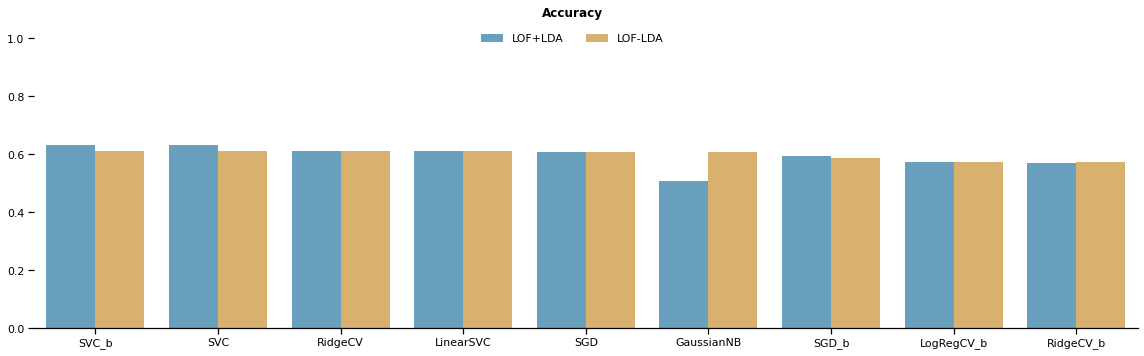

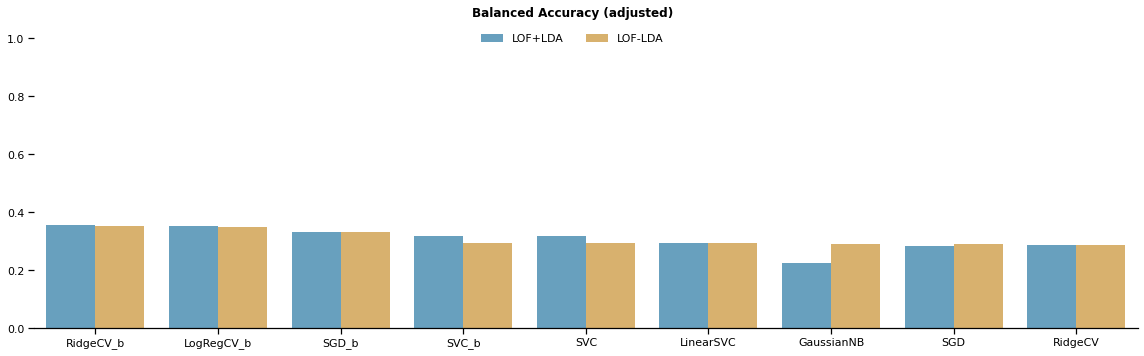

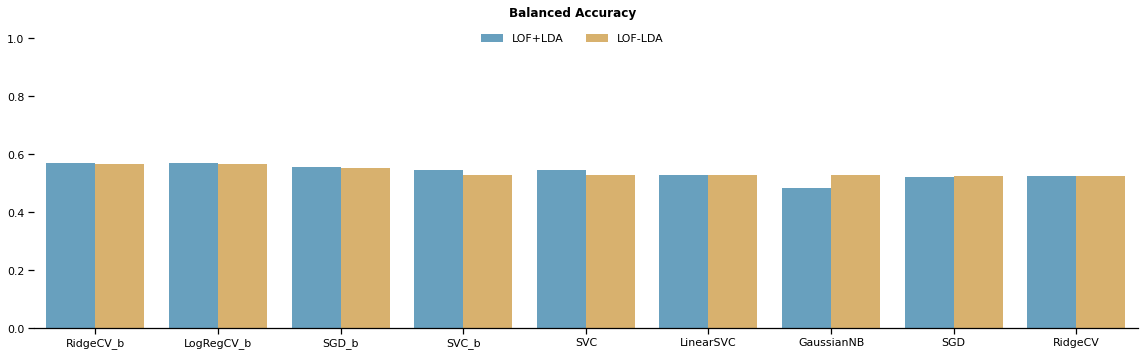

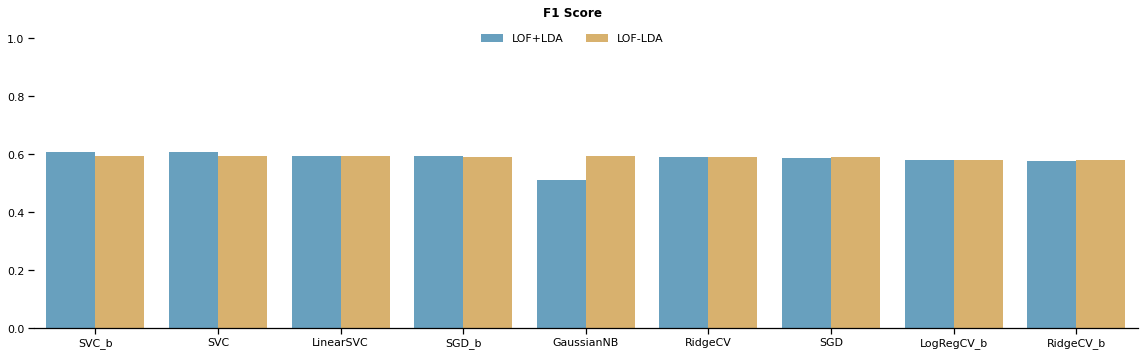

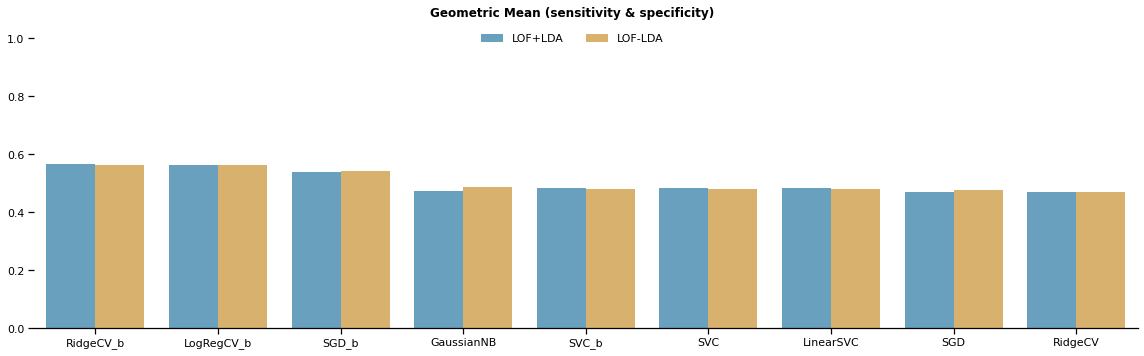

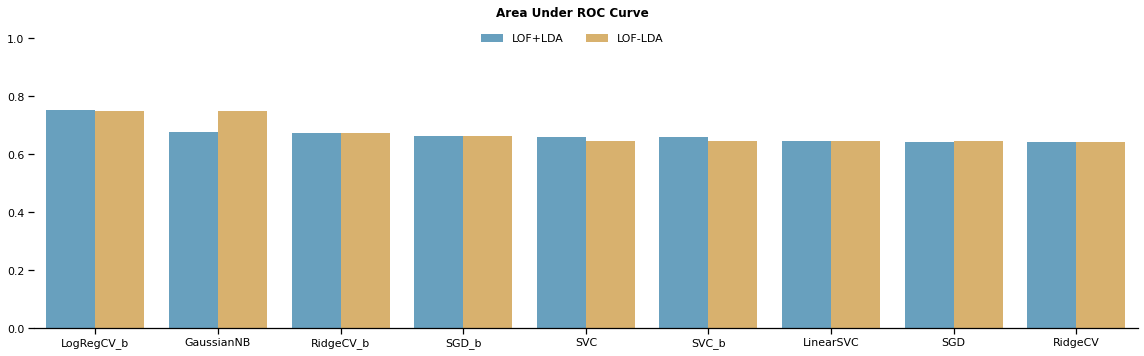

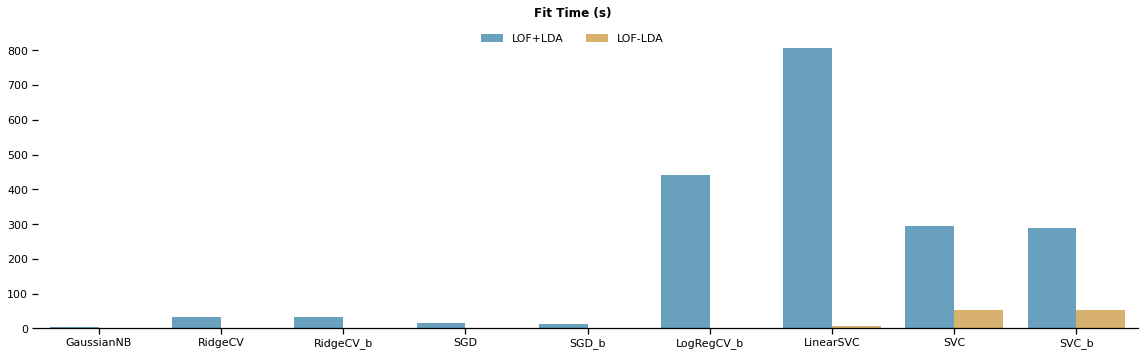

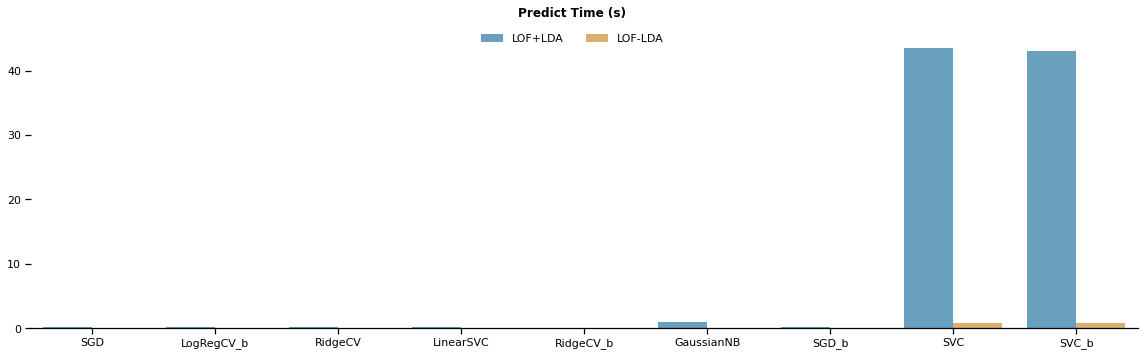

time: 3.11 s


In [14]:
for metric in tqdm(METRICS):
    plot_metric(metric, results_df)

# Prediction correlations

To estimate the degree of correlation between model predictions, we recorded an array of probability vector predictions per model per fold. The vectors are transformed to three columns that are reduced to one component with PCA. The absolute values of the correlation coefficients are calculated between these single components per model. These are averaged between folds for the final estimate.

<Figure size 864x864 with 0 Axes>

Pandas Apply: 100%|██████████| 1/1 [00:00<?, ?it/s]


Text(0.5, 0.98, 'prediction correlations: LOF+LDA')

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0.5, 0, 'GaussianNB'),
  Text(1.5, 0, 'LinearSVC'),
  Text(2.5, 0, 'LogRegCV_b'),
  Text(3.5, 0, 'RidgeCV_b'),
  Text(4.5, 0, 'RidgeCV'),
  Text(5.5, 0, 'SGD'),
  Text(6.5, 0, 'SGD_b'),
  Text(7.5, 0, 'SVC'),
  Text(8.5, 0, 'SVC_b')])

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0, 0.5, 'GaussianNB'),
  Text(0, 1.5, 'LinearSVC'),
  Text(0, 2.5, 'LogRegCV_b'),
  Text(0, 3.5, 'RidgeCV'),
  Text(0, 4.5, 'RidgeCV_b'),
  Text(0, 5.5, 'SGD'),
  Text(0, 6.5, 'SGD_b'),
  Text(0, 7.5, 'SVC'),
  Text(0, 8.5, 'SVC_b')])

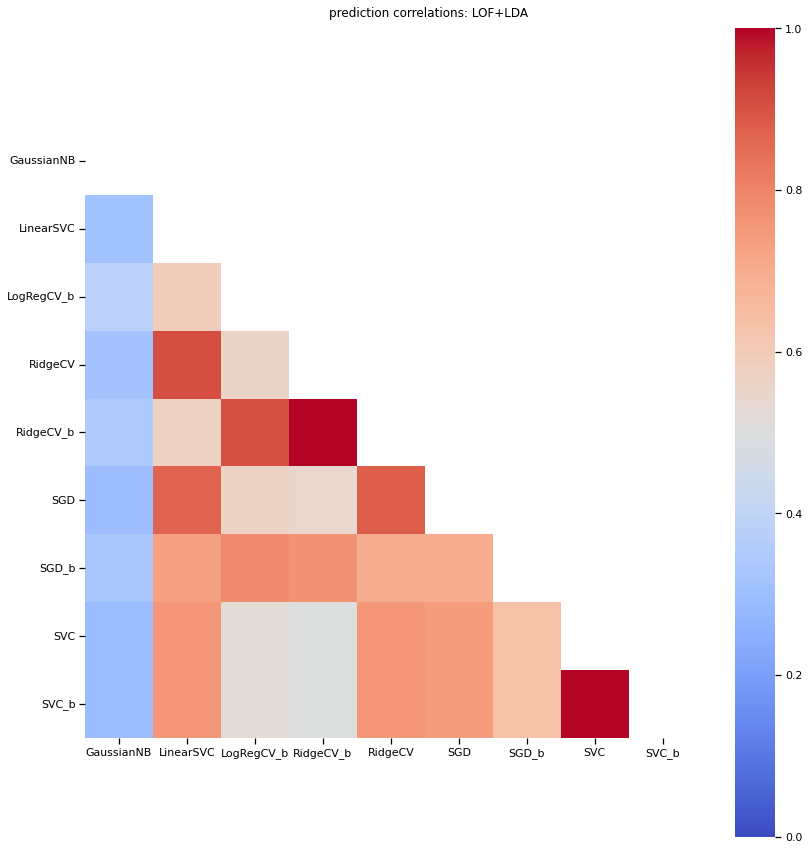

<Figure size 864x864 with 0 Axes>

Pandas Apply: 100%|██████████| 1/1 [00:00<?, ?it/s]


Text(0.5, 0.98, 'prediction correlations: LOF-LDA')

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0.5, 0, 'GaussianNB'),
  Text(1.5, 0, 'LinearSVC'),
  Text(2.5, 0, 'LogRegCV_b'),
  Text(3.5, 0, 'RidgeCV_b'),
  Text(4.5, 0, 'RidgeCV'),
  Text(5.5, 0, 'SGD'),
  Text(6.5, 0, 'SGD_b'),
  Text(7.5, 0, 'SVC'),
  Text(8.5, 0, 'SVC_b')])

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0, 0.5, 'GaussianNB'),
  Text(0, 1.5, 'LinearSVC'),
  Text(0, 2.5, 'LogRegCV_b'),
  Text(0, 3.5, 'RidgeCV'),
  Text(0, 4.5, 'RidgeCV_b'),
  Text(0, 5.5, 'SGD'),
  Text(0, 6.5, 'SGD_b'),
  Text(0, 7.5, 'SVC'),
  Text(0, 8.5, 'SVC_b')])

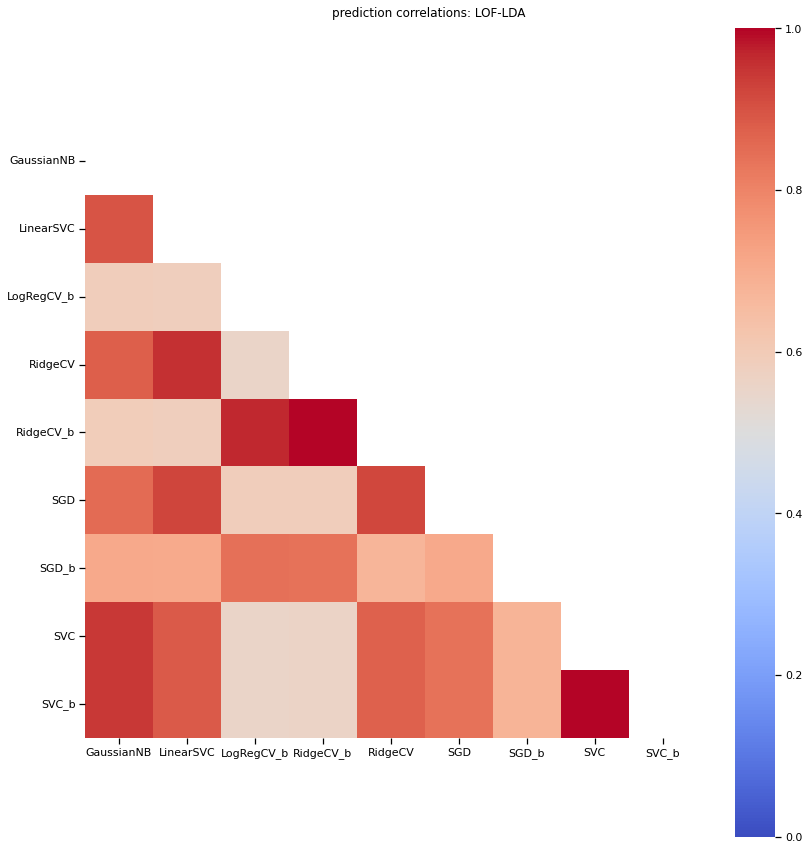

time: 2.2 s


In [15]:
def average_prediction_correlations(preprocessing: str) -> pd.DataFrame:
    """Estimates the correlations of model predictions and returns a DataFrame"""
    preprocess_df = pd.DataFrame(predictions_).query(
        f"preprocessing == '{preprocessing}'"
    )
    fold_correlation_dfs = []
    for fold in sorted(np.unique(preprocess_df.fold)):
        fold_df = preprocess_df.query(f"fold == {fold}")
        model_predictions = {
            model: np.squeeze(
                PCA(n_components=1, random_state=SEED).fit_transform(
                    pd.DataFrame(
                        np.hstack(
                            fold_df.query(f"model == '{model}'")
                            .y_pred.swifter.apply(np.asarray)
                            .values
                        )
                    )
                )
            )
            for model in MODELS
        }
        fold_correlation_dfs.append(
            pd.DataFrame(model_predictions).corr().swifter.apply(abs)
        )
    return (_ := pd.concat(fold_correlation_dfs)).groupby(_.index).mean()


for preprocessing in {"LOF-LDA", "LOF+LDA"}:
    plt.figure(figsize=(12, 12))
    # classifiers whose predictions do not vary (e.g., dummy) produce NaN correlations and are dropped from visualization
    g = sns.heatmap(
        data=(
            df := average_prediction_correlations(preprocessing)
            .dropna(axis="columns", how="all")
            .dropna(axis="index", how="all")
        ),
        vmin=0,
        vmax=1,
        cmap="coolwarm",
        square=True,
        mask=np.triu(np.ones_like(df, dtype=bool)),
    )
    plt.suptitle(f"prediction correlations: {preprocessing}")
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    del df
    del g
    _ = gc_collect()

# Discussion

The SVC classifiers performed noticeably better when the FRILL embeddings were combined with the LDA components. GaussianNB performed much better without the FRILL embeddings. For all other models, the difference is barely noticeable.

The biggest difference between the two correlation plots is that GaussianNB agrees with other classifiers much more when they are trained without the FRILL embeddings. Otherise, the same pattern may be observed in both plots but in a lesser degree when considering the full feature set.

In [16]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 10818.914283752441 s
time: 110 ms


[^top](#Contents)